In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pandas as pd
from scipy.io import loadmat
from datetime import datetime as dt
from glob import glob

In [2]:
def movavg(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
    for ibin in range(nbin):
        out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
    return out

In [3]:
def read_neuron(path, random_state=0):
    cm = loadmat(os.path.join(os.path.dirname(path), 'cm.mat'))['cm']

    ua = loadmat(path)['ua']
    cm = cm[:ua.shape[0]]
    
    exit_flag = 0
    X = []
    for istim in np.arange(1, 166):
        np.random.seed(165 * random_state + istim)
        _X = ua[(cm==istim).flatten(), :]
        nrep = _X.shape[0]
        
        if nrep < 3:
            exit_flag = 1
            break

        X.append(_X.mean(0))
    return exit_flag, np.array(X)

In [4]:
def gfoldername(date):
    return dt.strptime(date.replace("'", ""), '%d-%b-%Y %H:%M:%S').strftime('%Y-%m-%d_%H-%M')

In [5]:
itc = movavg(np.load('G:\Data\Fast\Both\ITCNoAvg.npy'), 25, 1)
pfc = movavg(np.load('G:\Data\Fast\Both\PFCNoAvg.npy'), 25, 1)

In [6]:
itc_jenab = []
df = pd.read_csv(r"G:\Data\Fast\Jenab\recordingInfo.csv")
dates = df[df['is_main'] == True].reset_index(drop=True)['session_date']
dates = dates.apply(gfoldername)
for date in dates:
    for neuronPath in glob(os.path.join(r'G:\Data\Fast\Jenab', date, 'Trial', '*u*_it*.mat')):
        ef, X = read_neuron(neuronPath, random_state=0)
        if ef == 0:
            itc_jenab.append(X)
itc_jenab = np.array(itc_jenab)

pfc_jenab = []
for date in dates:
    for neuronPath in glob(os.path.join(r'G:\Data\Fast\Jenab', date, 'Trial', '*u*_pfc*.mat')):
        ef, X = read_neuron(neuronPath, random_state=0)
        if ef == 0:
            pfc_jenab.append(X)
pfc_jenab = np.array(pfc_jenab)

# Zebel

df = pd.read_csv(r"G:\Data\Fast\Zebel\mainSessions.csv", header=None)
dates = df[0]

itc_zebel = []
for date in dates:
    for neuronPath in glob(os.path.join(r'G:\Data\Fast\Zebel', date, 'Trial', '*u*_it*.mat')):
        ef, X = read_neuron(neuronPath, random_state=0)
        if ef == 0:
            itc_zebel.append(X)
itc_zebel = np.array(itc_zebel)

pfc_zebel = []
for date in dates:
    for neuronPath in glob(os.path.join(r'G:\Data\Fast\Zebel', date, 'Trial', '*u*_pfc*.mat')):
        ef, X = read_neuron(neuronPath, random_state=0)
        if ef == 0:
            pfc_zebel.append(X)
pfc_zebel = np.array(pfc_zebel)

# Concatenate

itc = np.concatenate((itc_jenab, itc_zebel))
itc = np.transpose(itc, [1, 0, 2])

pfc = np.concatenate((pfc_jenab, pfc_zebel))
pfc = np.transpose(pfc, [1, 0, 2])

itc = movavg(itc, 25, 1)
pfc = movavg(pfc, 25, 1)

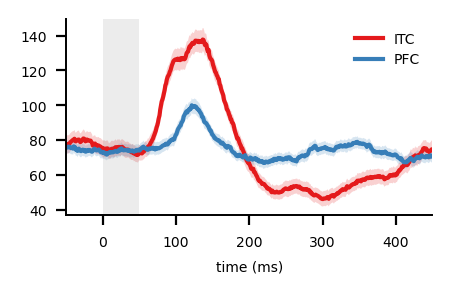

In [27]:
tim = np.arange(-200, 675) + 12.5
sns.set_palette('Set1')

cm = 1 / 2.54
fig, axs = plt.subplots(1, 1, figsize=(6 * cm, 4 * cm), dpi=200)
ax = axs

X = itc[:, 63, :]
ax.plot(tim, X.mean(0), label='ITC')
ax.fill_between(tim, \
    X.mean(0) + 1.96 / np.sqrt(X.shape[0]) * X.std(0), 
    X.mean(0) - 1.96 / np.sqrt(X.shape[0]) * X.std(0), 
    alpha=.2, label='_nolegend_')

X = pfc[:, 79, :]
ax.plot(tim, X.mean(0), label='PFC')
ax.fill_between(tim, \
    X.mean(0) + 1.96 / np.sqrt(X.shape[0]) * X.std(0), 
    X.mean(0) - 1.96 / np.sqrt(X.shape[0]) * X.std(0), 
    alpha=.2, label='_nolegend_')
ylim = ax.get_ylim()
ax.fill_between([0, 50], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.15, edgecolor=None)
ax.set_ylim(ylim)

axs.set_xlim(-50, 450)
ax.legend(frameon=False, fontsize=5)
ax.set_xlabel('time (ms)', fontsize=5)
ax.set_ylabel('Firing rate', fontsize=5)
ax.set_ylabel('')
axs.tick_params(axis='both', which='major', labelsize=5)
plt.setp(ax.spines.values(), linewidth=.7)


sns.despine()
fig.tight_layout()

plt.savefig('sample-psth.pdf')